<a href="https://colab.research.google.com/github/hyunicecream/ML-DL/blob/main/%08AutoEncoder%20LSTM(Mnist).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Dec 30 04:57:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    73W / 149W |   1271MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
# mnist 데이터를 다운로드한다
(d_train, y_train), (d_test, y_test) = mnist.load_data()
d_train.shape, y_train.shape

11501568/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,))

In [ ]:
# input data를 생성한다
x_train = d_train / 255
n_height = x_train.shape[1]
# n_height = 8
n_width = x_train.shape[2]
n_feat = 8   # 28 x 8

In [ ]:
# LSTM AutoEncoder
x_input = Input(batch_shape = (None, n_height, n_width))

# encoder 축소된 이미지 정보
e_lstm = Bidirectional(LSTM(n_feat, return_sequences=True), merge_mode = 'sum')(x_input)

# decoder 
d_lstm = Bidirectional(LSTM(n_feat, return_sequences=True), merge_mode = 'sum')(e_lstm)
y_output = TimeDistributed(Dense(n_width))(d_lstm)
# TimeDistributed -< FFN의 중간중간에 값을 뽑아 내라는 의미
# Dense만 있는 경우는 마지막 값만 출력

model = Model(x_input, y_output)
encoder = Model(x_input, e_lstm) # 중요 포인트
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
model.summary()
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 28, 8)            2368      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 28, 8)            1088      
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 28, 28)           252       
 ibuted)                                                         
                                                                 
Total params: 3,708
Trainable params: 3,708
Non-trainable params: 0
___________________________________________________________

In [ ]:
# autoencoder를 학습한다
hist = model.fit(x_train, x_train, epochs=50, batch_size=1024)

Epoch 1/50
59/59 [==============================] - 23s 38ms/step - loss: 0.0918
Epoch 2/50
59/59 [==============================] - 2s 39ms/step - loss: 0.0615
Epoch 3/50
59/59 [==============================] - 2s 39ms/step - loss: 0.0436
Epoch 4/50
59/59 [==============================] - 2s 38ms/step - loss: 0.0312
Epoch 5/50
59/59 [==============================] - 2s 38ms/step - loss: 0.0234
Epoch 6/50
59/59 [==============================] - 2s 42ms/step - loss: 0.0192
Epoch 7/50
59/59 [==============================] - 2s 41ms/step - loss: 0.0169
Epoch 8/50
59/59 [==============================] - 3s 44ms/step - loss: 0.0153
Epoch 9/50
59/59 [==============================] - 3s 42ms/step - loss: 0.0140
Epoch 10/50
59/59 [==============================] - 3s 43ms/step - loss: 0.0128
Epoch 11/50
59/59 [==============================] - 3s 44ms/step - loss: 0.0118
Epoch 12/50
59/59 [==============================] - 3s 43ms/step - loss: 0.0110
Epoch 13/50
59/59 [=================

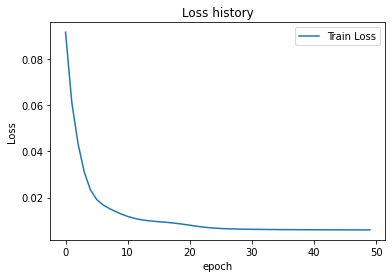

In [ ]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train Loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
# 학습된 autoencoder를 이용하여 입력 데이터의 차원을 축소한다.
x_encoded = encoder.predict(x_train).reshape(-1, 28 * 8)

In [ ]:
# K-means++ 알고리즘으로 차원이 축소된 이미지를 10 그룹으로 분류한다.
km = KMeans(n_clusters=10, init='k-means++', n_init=3, max_iter=300, tol=1e-04, random_state=0)
km = km.fit(x_encoded)
clust = km.predict(x_encoded)

<Figure size 576x144 with 0 Axes>

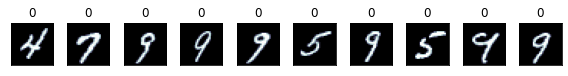

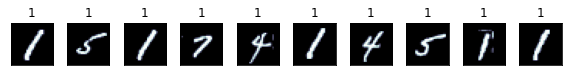

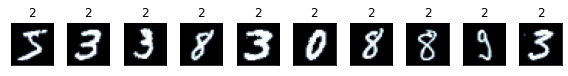

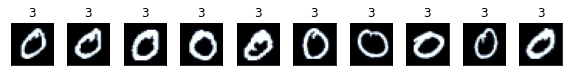

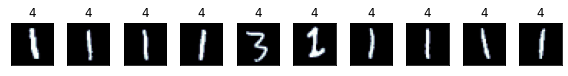

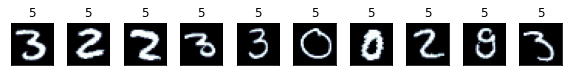

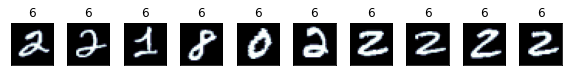

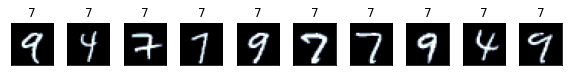

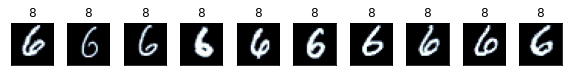

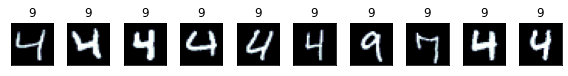

In [ ]:
# cluster 별로 이미지를 확인한다.
f = plt.figure(figsize=(8, 2))
for k in np.unique(clust):
    # cluster가 i인 imageX image 10개를 찾는다.
    idx = np.where(clust == k)[0][:10]
    
    f = plt.figure(figsize=(8, 2))
    for i in range(10):
        image = x_train[idx[i]].reshape(28,28)
        ax = f.add_subplot(1, 10, i + 1)
        ax.imshow(image, cmap=plt.cm.bone)
        ax.grid(False)
        ax.set_title(k)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        plt.tight_layout()